In [30]:
from Data_Loader import load_data
from Train2 import trainCox_nnet

import torch
import numpy as np
import pandas as pd
from torch.utils.data.dataloader import DataLoader

In [31]:
dtype = torch.FloatTensor
''' Net Settings'''
Hidden_Nodes = 143 ###number of hidden nodes
Out_Nodes = 30 ###number of hidden nodes in the last hidden layer
''' Initialize '''
Initial_Learning_Rate = [0.01, 0.001, 0.00075]
L2_Lambda = [0.01, 0.005, 0.001]
L1_Lambda = [0.01, 0.005, 0.001]
num_epochs = 3 ###for pancreas
Num_EPOCHS = 3 ###for lung
###sub-network setup
Dropout_Rate = [0.7, 0.5]

Data preprocessing 

In [32]:
from Data_extraction_lung import data_norm_df_lung, output_df_lung

data_norm_df_lung= data_norm_df_lung.reset_index(drop=True)
output_df_lung = output_df_lung.reset_index(drop=True)

(555, 5)


In [33]:
# from Data_extraction_pancreas import data_norm_df_pancreas, output_df_pancreas
# data_norm_df_pancreas= data_norm_df_pancreas.reset_index(drop=True)
# output_df_pancreas = output_df_pancreas.reset_index(drop=True)

In [36]:
data = pd.concat([data_norm_df_lung,output_df_lung], axis=1)
x, ytime, yevent, age = load_data(data, dtype)

In [37]:
#Standardisation
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

#Variance threshold
# from sklearn.feature_selection import VarianceThreshold
# selector = VarianceThreshold(0.2)
# x = selector.fit_transform(x)

#PCA
# from sklearn.decomposition import PCA
# pca = PCA(.95)
# pca.fit(x)
# x = pca.transform(x)
# x= torch.from_numpy(x)
# print(x.shape)

In [38]:
from Data_Loader import CustomDataset

batch_size=32
data2 = CustomDataset(x, ytime, yevent, age)
In_Nodes = len(x[0,:]) ###number of genes
print(np.shape(x))

Grid search for the optimal learning rate, regularisation l1 and L2, drop out 

In [40]:
opt_l2_loss = 0
opt_l1_loss = 0
opt_lr_loss = 0
opt_do_loss = 0
opt_loss = torch.Tensor([float("Inf")])
###if gpu is being used
if torch.cuda.is_available():
	opt_loss = opt_loss.cuda()
###
opt_c_index_va = 0
opt_c_index_tr = 0

In [41]:
# for l2 in L2_Lambda:
# 	for lr in Initial_Learning_Rate:
# 		for l1 in L1_Lambda:
# 			history_train, history_val = trainCox_nnet(data2, \
# 				In_Nodes, Hidden_Nodes, Out_Nodes, \
# 				lr, l2, l1, num_epochs, 0.5, batch_size)
# 			c_index_val_fold0 = [k['c_index'] for k in history_val[0]]
# 			c_index_val_fold1 = [k['c_index'] for k in history_val[1]]
# 			c_index=np.mean([c_index_val_fold0[-1],c_index_val_fold1[-1]])
# 			if c_index==0: 
# 				break
# 			elif c_index > opt_c_index_va:
# 				opt_l2_loss = l2
# 				opt_lr_loss = lr
# 				opt_l1_loss = l1
# 				opt_do_loss = 0.5
# 				opt_c_index_va = c_index
# 				# opt_c_index_tr = c_index_tr
# 				# opt_c_index_va = c_index_va
# 			print ("L2: ", l2, "L1:", l1, "LR: ", lr, "c_index", opt_c_index_va)

In [42]:
opt_l2_loss, opt_l1_loss, opt_lr_loss, opt_do_loss = 0.001, 0.001, 0.001, 0.5
print(In_Nodes)
# print(opt_l2_loss, opt_l1_loss, opt_lr_loss, opt_do_loss)

60660


Train the model 

In [43]:
###train Cox-nnet with optimal hyperparameters using train data, and then evaluate the trained model with test data
###Note that test data are only used to evaluate the trained Cox-nnet
loss_batch_train, history_train, history_val = trainCox_nnet(data2, \
			In_Nodes, Hidden_Nodes, Out_Nodes, \
			opt_lr_loss, opt_l2_loss, opt_l1_loss, Num_EPOCHS, opt_do_loss, batch_size)
print ("Optimal L2: ", opt_l2_loss, "Optimal LR: ", opt_lr_loss)
# print("C-index in Test: ", c_index_te)

------------fold no---------0----------------------
Epoch [0], loss: 2.6425, c_index: 0.6296
Epoch [1], loss: 2.3661, c_index: 0.6296
Epoch [2], loss: 2.3034, c_index: 0.6366
Epoch [3], loss: 2.3017, c_index: 0.6347
------------fold no---------1----------------------
Epoch [0], loss: 2.5713, c_index: 0.3926
Epoch [1], loss: 2.4168, c_index: 0.6039
Epoch [2], loss: 2.4182, c_index: 0.3918
Epoch [3], loss: 2.3848, c_index: 0.6049
------------fold no---------2----------------------
Epoch [0], loss: 2.3685, c_index: 0.6183
Epoch [1], loss: 2.4225, c_index: 0.6197
Epoch [2], loss: 2.3631, c_index: 0.6197
Epoch [3], loss: 2.3772, c_index: 0.6275
------------fold no---------3----------------------
Epoch [0], loss: 2.8536, c_index: 0.5443
Epoch [1], loss: 2.5240, c_index: 0.5553
Epoch [2], loss: 2.4258, c_index: 0.5543
Epoch [3], loss: 2.4088, c_index: 0.5554
------------fold no---------4----------------------
Epoch [0], loss: 3.2016, c_index: 0.5633
Epoch [1], loss: 3.0012, c_index: 0.5569
Ep

Performances and visualisation 

In [16]:
loss_train_fold0 = [k['loss'] for k in history_train[0]]
loss_val_fold0 = [k['loss'] for k in history_val[0]] 
c_index_train_fold0 = [k['c_index'] for k in history_train[0]]
c_index_val_fold0 = [k['c_index'] for k in history_val[0]]


loss_train_fold1 = [k['loss'] for k in history_train[1]]
loss_val_fold1 = [k['loss'] for k in history_val[1]] 
c_index_train_fold1 = [k['c_index'] for k in history_train[1]]
c_index_val_fold1 = [k['c_index'] for k in history_val[1]]

loss_train_fold2 = [k['loss'] for k in history_train[2]]
loss_val_fold2 = [k['loss'] for k in history_val[2]] 
c_index_train_fold2 = [k['c_index'] for k in history_train[2]]
c_index_val_fold2 = [k['c_index'] for k in history_val[2]]

loss_train_fold3 = [k['loss'] for k in history_train[3]]
loss_val_fold3 = [k['loss'] for k in history_val[3]] 
c_index_train_fold3 = [k['c_index'] for k in history_train[3]]
c_index_val_fold3 = [k['c_index'] for k in history_val[3]]

loss_train_fold4 = [k['loss'] for k in history_train[4]]
loss_val_fold4 = [k['loss'] for k in history_val[4]] 
c_index_train_fold4 = [k['c_index'] for k in history_train[4]]
c_index_val_fold4 = [k['c_index'] for k in history_val[4]]


In [17]:
loss_train_fold5 = [k['loss'] for k in history_train[5]]
loss_val_fold5 = [k['loss'] for k in history_val[5]] 
c_index_train_fold5 = [k['c_index'] for k in history_train[5]]
c_index_val_fold5 = [k['c_index'] for k in history_val[5]]


loss_train_fold6 = [k['loss'] for k in history_train[6]]
loss_val_fold6 = [k['loss'] for k in history_val[6]] 
c_index_train_fold6 = [k['c_index'] for k in history_train[6]]
c_index_val_fold6 = [k['c_index'] for k in history_val[6]]

loss_train_fold7 = [k['loss'] for k in history_train[7]]
loss_val_fold7 = [k['loss'] for k in history_val[7]] 
c_index_train_fold7 = [k['c_index'] for k in history_train[7]]
c_index_val_fold7 = [k['c_index'] for k in history_val[7]]

loss_train_fold8 = [k['loss'] for k in history_train[8]]
loss_val_fold8 = [k['loss'] for k in history_val[8]] 
c_index_train_fold8 = [k['c_index'] for k in history_train[8]]
c_index_val_fold8 = [k['c_index'] for k in history_val[8]]

loss_train_fold9 = [k['loss'] for k in history_train[9]]
loss_val_fold9 = [k['loss'] for k in history_val[9]] 
c_index_train_fold9 = [k['c_index'] for k in history_train[9]]
c_index_val_fold9 = [k['c_index'] for k in history_val[9]]


In [18]:
epoch = np.arange(0,Num_EPOCHS+1)

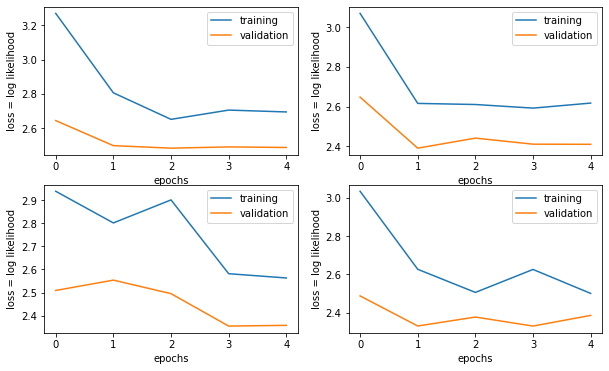

In [19]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, loss_train_fold0, label = 'training')
plt.plot(epoch, loss_val_fold0, label = 'validation')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, loss_train_fold1, label = 'training')
plt.plot(epoch, loss_val_fold1, label = 'validation')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



plt.subplot(223)
plt.plot(epoch, loss_train_fold2, label = 'training')
plt.plot(epoch, loss_val_fold2, label = 'validation')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, loss_train_fold4, label = 'training')
plt.plot(epoch, loss_val_fold4, label = 'validation')
plt.ylabel('loss = log likelihood')
plt.xlabel('epochs')
plt.legend()



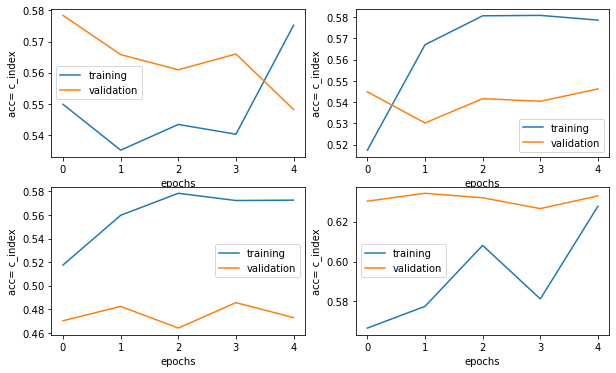

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.plot(epoch, c_index_train_fold0, label = 'training')
plt.plot(epoch, c_index_val_fold0, label = 'validation')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(222)
plt.plot(epoch, c_index_train_fold1, label = 'training')
plt.plot(epoch, c_index_val_fold1, label = 'validation')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(223)
plt.plot(epoch, c_index_train_fold3, label = 'training')
plt.plot(epoch, c_index_val_fold3, label = 'validation')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()

plt.subplot(224)
plt.plot(epoch, c_index_train_fold4, label = 'training')
plt.plot(epoch, c_index_val_fold4, label = 'validation')
plt.ylabel('acc= c_index')
plt.xlabel('epochs')
plt.legend()


In [21]:
#result cross validation

print(np.mean([c_index_val_fold1[4],  c_index_val_fold0[4], c_index_val_fold3[4], c_index_val_fold2[4],c_index_val_fold4[4]]))
print(np.std([c_index_val_fold1[4],  c_index_val_fold0[4], c_index_val_fold3[4], c_index_val_fold2[4],c_index_val_fold4[4]]))
print(([c_index_val_fold1[4],  c_index_val_fold0[4], c_index_val_fold3[4], c_index_val_fold2[4],c_index_val_fold4[4]]))


0.5791015028953552
0.07705310778571102
[0.5462051033973694, 0.5481851100921631, 0.47295188903808594, 0.6951999068260193, 0.6329655051231384]


In [22]:
#result cross validation

print(np.mean([c_index_val_fold0[6],  c_index_val_fold1[6], c_index_val_fold2[6]]))
print(np.std([c_index_val_fold0[6],  c_index_val_fold1[6], c_index_val_fold2[6]]))
print([c_index_val_fold0[6],  c_index_val_fold1[6], c_index_val_fold2[6]])



0.6153730948766073
0.04397033970324299
[0.6420367956161499, 0.5533907413482666, 0.6506917476654053]


PCA

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from Data_Loader import sort_data
x, ytime, yevent, age = sort_data(data)
x = StandardScaler().fit_transform(x)
pca = PCA(100)
pca.fit(x)
x = pca.transform(x)

In [8]:
np.sum(pca.explained_variance_ratio_)

0.6827715521313867

Transfer learning 

In [44]:
from Data_extraction_pancreas import data_norm_df_pancreas, output_df_pancreas
data_norm_df_pancreas= data_norm_df_pancreas.reset_index(drop=True)
output_df_pancreas = output_df_pancreas.reset_index(drop=True)



In [45]:
data_pancreas = pd.concat([data_norm_df_pancreas,output_df_pancreas], axis=1)
x_pancreas, ytime_pancreas, yevent_pancreas, age_pancreas = load_data(data_pancreas, dtype)

from sklearn.preprocessing import StandardScaler
x_pancreas = StandardScaler().fit_transform(x_pancreas)

In [46]:
from Data_Loader import CustomDataset
batch_size=32
data2_pancreas = CustomDataset(x_pancreas, ytime_pancreas, yevent_pancreas, age_pancreas)

In [47]:
print(len(x[0,:]))
print(len(x_pancreas[0,:]))

60660
60660


In [48]:
from Model2 import Cox_nnet



import torch
import torch.optim as optim
import copy
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data.dataloader import DataLoader

In_Nodes = 60660
net = Cox_nnet(In_Nodes, Hidden_Nodes, Out_Nodes, 0.5)




In [49]:
from sksurv.metrics import concordance_index_censored
from Survival_CostFunc_CIndex import R_set, neg_par_log_likelihood, c_index

class Cox_nnet_transfer(nn.Module):
    def __init__(self, In_Nodes, Hidden_Nodes, Out_Nodes, Cox_nnet, Dropout): 
        super(Cox_nnet_transfer, self).__init__()
        self.trainer = nn.Sequential(*list(Cox_nnet.children())[:-1]) # strips off last linear layer from Cox_nnet
        # for param in self.trainer.parameters(): 
        #     param.requires_grad = False
        self.classifier = nn.Linear(Out_Nodes+1, 1, bias=False)
        self.classifier.weight.data.uniform_(-0.001, 0.001)
        

        
    def forward(self, x_1, x_2):
        #Normal 1 layer
        x_1=self.trainer(x_1)
        x_cat = torch.cat((x_1, x_2), 1)
        lin_pred=self.classifier(x_cat)
        return lin_pred

    def training_step(self, batch): 
        x_train_b, ytime_train_b, yevent_train_b, age_train_b = batch
        # print(batch)
        pred = self(x_train_b.float(), age_train_b) ###Forward
        loss = neg_par_log_likelihood(pred, ytime_train_b, yevent_train_b) ###calculate loss
        acc = c_index(pred, ytime_train_b, yevent_train_b) #calculate accuracy
        return{'val_loss': loss, 'val_acc': acc}

    def training_epoch_end(self, pred):
        batch_losses = [x['val_loss'] for x in pred]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in pred]
        epoch_acc = torch.stack(batch_accs).mean()
        return{'loss': epoch_loss.item(), 'c_index': epoch_acc.item()}

    def validation_step(self, batch): 
        x_eval_b, ytime_eval_b, yevent_eval_b, age_eval_b = batch
        eval_pred = self(x_eval_b.float(), age_eval_b)
        loss = neg_par_log_likelihood(eval_pred, ytime_eval_b, yevent_eval_b)
        # acc= concordance_index_censored(yevent_eval_b, ytime_eval_b,eval_pred)
        acc = c_index(eval_pred, ytime_eval_b, yevent_eval_b)
        return{'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, pred): 
        batch_losses = [x['val_loss'] for x in pred]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in pred]
        epoch_acc = torch.stack(batch_accs).mean()
        return{'loss': epoch_loss.item(), 'c_index': epoch_acc.item()}
    
    def epoch_end(self, epoch, result): 
        print("Epoch [{}], loss: {:.4f}, c_index: {:.4f}".format(epoch, result['loss'], result['c_index']))

In [50]:
my_model = Cox_nnet_transfer(In_Nodes, Hidden_Nodes, Out_Nodes, net, 0.5)

In [51]:
print(*list(my_model.children()))
# trainer = nn.Sequential(*list(net.children())[:-1]) # strips off last linear layer from Cox_nnet
# print(trainer)

Sequential(
  (0): Linear(in_features=60660, out_features=143, bias=True)
  (1): BatchNorm1d(143, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Tanh()
  (4): Linear(in_features=143, out_features=30, bias=True)
  (5): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Tanh()
) Linear(in_features=31, out_features=1, bias=False)


In [52]:
def reset_weights(m):
	for layer in m.children():
		if hasattr(layer, 'reset_parameters'):
			layer.reset_parameters()


dtype = torch.FloatTensor
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
history_val_pancreas=[[],[],[],[],[]]
history_train_pancreas=[[],[],[],[],[]]
for fold,(train_idx,test_idx) in enumerate(kfold.split(data2_pancreas)):
    my_model = Cox_nnet_transfer(In_Nodes, Hidden_Nodes, Out_Nodes, net, 0.5)
    opt = optim.Adam(my_model.parameters(), lr=opt_lr_loss, weight_decay = opt_l2_loss)
    print('------------fold no---------{}----------------------'.format(fold))
    train_loader = DataLoader(data2_pancreas, batch_size=15, sampler=train_idx)
    val_loader = DataLoader(data2_pancreas, batch_size=15, sampler=test_idx)
    # print(train_idx)
    for epoch in range(num_epochs+1):
        #training phase
        pred_train=[]
        for batch in train_loader: 
            loss = my_model.training_step(batch)
            loss = loss['val_loss']
            regularization_loss = 0
            for param in net.parameters():
                regularization_loss += torch.sum(abs(param))
            loss = loss+0.001*regularization_loss
            loss_batch_train.append(loss)
            loss.backward() ###calculate gradientsloss = loss['val_loss']
            opt.step() ###update weights and biases
            opt.zero_grad() ###reset gradients to zeros
            pred_train.append(my_model.training_step(batch))
        result_train = my_model.training_epoch_end(pred_train)
        pred_val = 	[my_model.validation_step(batch) for batch in val_loader]
        result_val = my_model.validation_epoch_end(pred_val)
        my_model.epoch_end(epoch, result_val)
        history_val_pancreas[fold].append(result_val)
        history_train_pancreas[fold].append(result_train)
        # pred_final = my_model(train_x, train_age)
    # my_model.apply(reset_weights)



------------fold no---------0----------------------
Epoch [0], loss: 5.4918, c_index: 0.4400
Epoch [1], loss: 1.6370, c_index: 0.5600
Epoch [2], loss: 1.5806, c_index: 0.5802
Epoch [3], loss: 2.1210, c_index: 0.4348
------------fold no---------1----------------------
Epoch [0], loss: 2.3212, c_index: 0.5899
Epoch [1], loss: 2.1320, c_index: 0.5744
Epoch [2], loss: 1.8623, c_index: 0.5801
Epoch [3], loss: 1.8101, c_index: 0.5761
------------fold no---------2----------------------
Epoch [0], loss: 1.7389, c_index: 0.4925
Epoch [1], loss: 1.2625, c_index: 0.5179
Epoch [2], loss: 1.4201, c_index: 0.4971
Epoch [3], loss: 1.8353, c_index: 0.4971
------------fold no---------3----------------------
Epoch [0], loss: 1.6557, c_index: 0.6286
Epoch [1], loss: 1.6901, c_index: 0.6322
Epoch [2], loss: 1.7792, c_index: 0.6322
Epoch [3], loss: 2.1507, c_index: 0.6322
------------fold no---------4----------------------
Epoch [0], loss: 2.1454, c_index: 0.4458
Epoch [1], loss: 1.7782, c_index: 0.4458
Ep

In [53]:
epoch = num_epochs+1

In [54]:
loss_train_fold0_pancreas = [k['loss'] for k in history_train_pancreas[0]]
loss_val_fold0_pancreas = [k['loss'] for k in history_val_pancreas[0]] 
c_index_train_fold0_pancreas = [k['c_index'] for k in history_train_pancreas[0]]
c_index_val_fold0_pancreas = [k['c_index'] for k in history_val_pancreas[0]]

loss_train_fold1_pancreas = [k['loss'] for k in history_train_pancreas[1]]
loss_val_fold1_pancreas = [k['loss'] for k in history_val_pancreas[1]] 
c_index_train_fold1_pancreas = [k['c_index'] for k in history_train_pancreas[1]]
c_index_val_fold1_pancreas = [k['c_index'] for k in history_val_pancreas[1]]

loss_train_fold2_pancreas = [k['loss'] for k in history_train_pancreas[2]]
loss_val_fold2_pancreas = [k['loss'] for k in history_val_pancreas[2]] 
c_index_train_fold2_pancreas = [k['c_index'] for k in history_train_pancreas[2]]
c_index_val_fold2_pancreas = [k['c_index'] for k in history_val_pancreas[2]]

loss_train_fold3_pancreas = [k['loss'] for k in history_train_pancreas[3]]
loss_val_fold3_pancreas = [k['loss'] for k in history_val_pancreas[3]] 
c_index_train_fold3_pancreas = [k['c_index'] for k in history_train_pancreas[3]]
c_index_val_fold3_pancreas = [k['c_index'] for k in history_val_pancreas[3]]

loss_train_fold4_pancreas = [k['loss'] for k in history_train_pancreas[4]]
loss_val_fold4_pancreas = [k['loss'] for k in history_val_pancreas[4]] 
c_index_train_fold4_pancreas = [k['c_index'] for k in history_train_pancreas[4]]
c_index_val_fold4_pancreas = [k['c_index'] for k in history_val_pancreas[4]]


In [55]:
epoch = np.arange(0,num_epochs+1)

In [56]:
# import matplotlib.pyplot as plt 
# plt.figure(figsize=(10,6))
# plt.subplot(221)
# plt.plot(epoch, loss_train_fold4_pancreas, label = 'training')
# plt.plot(epoch, loss_val_fold4_pancreas, label = 'testing')
# plt.ylabel('loss = log likelihood')
# plt.xlabel('epochs')
# plt.legend()

# plt.subplot(222)
# plt.plot(epoch, loss_train_fold1_pancreas, label = 'training')
# plt.plot(epoch, loss_val_fold1_pancreas, label = 'testing')
# plt.ylabel('loss = log likelihood')
# plt.xlabel('epochs')
# plt.legend()



# plt.subplot(223)
# plt.plot(epoch, loss_train_fold2_pancreas, label = 'training')
# plt.plot(epoch, loss_val_fold2_pancreas, label = 'testing')
# plt.ylabel('loss = log likelihood')
# plt.xlabel('epochs')
# plt.legend()

# plt.subplot(224)
# plt.plot(epoch, loss_train_fold0_pancreas, label = 'training')
# plt.plot(epoch, loss_val_fold0_pancreas, label = 'testing')
# plt.ylabel('loss = log likelihood')
# plt.xlabel('epochs')
# plt.legend()



In [57]:
# plt.figure(figsize=(10,6))
# plt.subplot(221)
# plt.plot(epoch, c_index_train_fold0_pancreas, label = 'training')
# plt.plot(epoch, c_index_val_fold0_pancreas, label = 'testing')
# plt.ylabel('acc= c_index')
# plt.xlabel('epochs')
# plt.legend()

# plt.subplot(222)
# plt.plot(epoch, c_index_train_fold1_pancreas, label = 'training')
# plt.plot(epoch, c_index_val_fold1_pancreas, label = 'testing')
# plt.ylabel('acc= c_index')
# plt.xlabel('epochs')
# plt.legend()

# plt.subplot(223)
# plt.plot(epoch, c_index_train_fold3_pancreas, label = 'training')
# plt.plot(epoch, c_index_val_fold3_pancreas, label = 'testing')
# plt.ylabel('acc= c_index')
# plt.xlabel('epochs')
# plt.legend()

# plt.subplot(224)
# plt.plot(epoch, c_index_train_fold4_pancreas, label = 'training')
# plt.plot(epoch, c_index_val_fold4_pancreas, label = 'testing')
# plt.ylabel('acc= c_index')
# plt.xlabel('epochs')
# plt.legend()


In [58]:
print(np.mean([c_index_val_fold0_pancreas[1],c_index_val_fold1_pancreas[1],c_index_val_fold2_pancreas[1],c_index_val_fold3_pancreas[1],c_index_val_fold4_pancreas[1]]))
print(([c_index_val_fold0_pancreas[1],c_index_val_fold1_pancreas[1],c_index_val_fold2_pancreas[1],c_index_val_fold3_pancreas[1],c_index_val_fold4_pancreas[1]]))

0.546066689491272
[0.5600358843803406, 0.5743802785873413, 0.5178952813148499, 0.6322091817855835, 0.44581282138824463]
